In [1]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")

from factor_vae import FactorVAEDSprites, Discriminator
from datasets import train_test_random_split, load_dsprites, CustomDataset
from train import train_factor_vae, test_factor_vae

In [2]:
dataset = load_dsprites("../datasets/dsprites.npz",False)
imgs = dataset["imgs"]

In [14]:
data_size = 10000
data = CustomDataset(imgs,data_size)

In [15]:
data_train, data_test = train_test_random_split(data, 0.8)

In [16]:
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size,shuffle=False)

In [17]:
model = FactorVAEDSprites()
discriminator = Discriminator(nb_layers=4,hidden_dim=500)
vae_optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
gamma = 0
epochs = 10

In [18]:
train_factor_vae(model, discriminator, epochs, train_loader, vae_optimizer, discriminator_optimizer, gamma, 'bernoulli')

Epoch 0 finished, loss: 857.4885119628906, recon loss: 853.2968159179687, kl div: 4.1916992328641935
Epoch 1 finished, loss: 572.7160493164063, recon loss: 571.2859365234375, kl div: 1.4301109642982484
Epoch 2 finished, loss: 572.6941806640625, recon loss: 571.6552436523438, kl div: 1.0389371218681336
Epoch 3 finished, loss: 570.1628872070313, recon loss: 569.54068359375, kl div: 0.6222026462554932
Epoch 4 finished, loss: 560.9791882324218, recon loss: 560.2138718261718, kl div: 0.7653160445690155
Epoch 5 finished, loss: 500.1370712890625, recon loss: 498.0384404296875, kl div: 2.098632067680359
Epoch 6 finished, loss: 315.9102711181641, recon loss: 312.47394409179685, kl div: 3.436327533721924
Epoch 7 finished, loss: 208.46176623535158, recon loss: 204.6762109375, kl div: 3.785555248260498
Epoch 8 finished, loss: 172.83520886230468, recon loss: 169.14043591308592, kl div: 3.6947728805541993
Epoch 9 finished, loss: 153.4838731689453, recon loss: 149.9352440185547, kl div: 3.54862916183

([857.4885119628906,
  572.7160493164063,
  572.6941806640625,
  570.1628872070313,
  560.9791882324218,
  500.1370712890625,
  315.9102711181641,
  208.46176623535158,
  172.83520886230468,
  153.4838731689453],
 [853.2968159179687,
  571.2859365234375,
  571.6552436523438,
  569.54068359375,
  560.2138718261718,
  498.0384404296875,
  312.47394409179685,
  204.6762109375,
  169.14043591308592,
  149.9352440185547],
 [4.1916992328641935,
  1.4301109642982484,
  1.0389371218681336,
  0.6222026462554932,
  0.7653160445690155,
  2.098632067680359,
  3.436327533721924,
  3.785555248260498,
  3.6947728805541993,
  3.5486291618347168],
 [0.5432324377764016,
  0.943759884595871,
  0.8597535957098007,
  0.36490545292198656,
  0.9403416843414306,
  3.7101991577148437,
  4.562450271606445,
  5.15753804397583,
  5.222358066558838,
  5.50768318939209],
 [0.49678655529022214,
  0.44937092876434326,
  0.5107474191188812,
  0.6261673803329468,
  0.4918914598226547,
  0.12583505341410636,
  0.0435349

In [19]:
test_factor_vae(model, discriminator, test_loader, gamma, 'bernoulli')

Test loss: 146.44493913650513


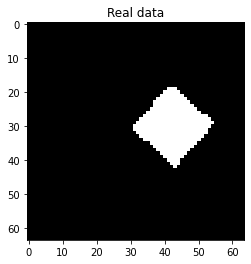

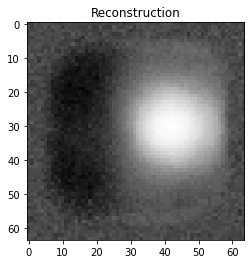

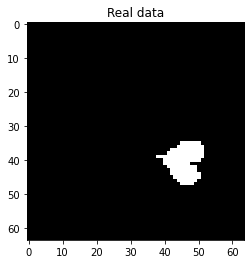

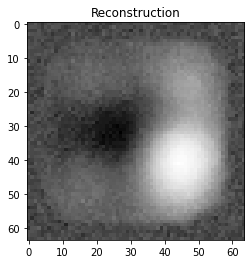

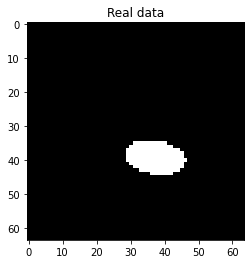

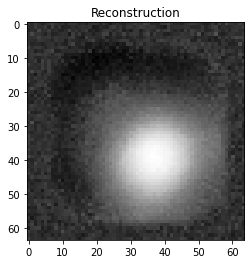

In [20]:
with torch.no_grad():
    for i in [1,15,20]:
        data, _ = data_test[i]
        data = data.float()
        recon, mu, logvar, z = model(data)
        plt.imshow(data, cmap='Greys_r')
        plt.title("Real data")
        plt.show()
        plt.imshow(recon.squeeze(), cmap='Greys_r')
        plt.title("Reconstruction")
        plt.show()

In [21]:
dataset.allow_pickle = True
latents_sizes = dataset['metadata'][()][b'latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
    return np.dot(latents, latents_bases).astype(int)

def sample_latent(size=1, fixed = None):
    samples = np.zeros((size, latents_sizes.size))
    for lat_i, lat_size in enumerate(latents_sizes):
        if fixed == lat_i:
            fixed_value = np.random.randint(lat_size, size=1)
            samples[:, lat_i] = np.full(size, fixed_value)
        else:
            samples[:, lat_i] = np.random.randint(lat_size, size=size)
    return samples

In [22]:
def compute_latent_variance(size):
    sample = sample_latent(size)
    imgs_sampled = imgs[latent_to_index(sample)]
    latents = np.zeros((size,10))
    for i,data in enumerate(imgs_sampled):
        data = torch.from_numpy(data).unsqueeze(0).float().unsqueeze(0)
        recon, mu, logvar, z = model(data)
        z = np.array(z.squeeze().detach().numpy())
        latents[i] = z
    global_vars = np.var(latents, axis = 0) 
    return global_vars

latents_global_variance = compute_latent_variance(1000)


In [23]:
def FactorVAE_entanglement_metric(nb_samples,sample_size):
    loss = 0
    classification = np.zeros((len(latents_sizes),10))
    for i in range(nb_samples):
        k = np.random.randint(len(latents_sizes)-1)+1
        latents_sampled = sample_latent(size=sample_size, fixed=k)
        indices_sampled = latent_to_index(latents_sampled)
        imgs_sampled = imgs[indices_sampled]
        latents_rep = np.zeros((sample_size,10))
        for data in imgs_sampled:
            data = torch.from_numpy(data).unsqueeze(0).float().unsqueeze(0)
            recon, mu, logvar, z = model(data)
            z = np.array(z.squeeze().detach().numpy())
            latents_rep[i] = z
        latents_var = np.var(latents_rep, axis = 0) 
        latents_var_normalized = np.divide(latents_var, latents_global_variance)
        idx = np.argmin(latents_var_normalized)
        classification[k,idx]+=1
    print(classification)
    for i in range(len(latents_sizes)):
        loss = loss + np.sum(classification[i])- np.max(classification[i])
    return loss/nb_samples

In [13]:
FactorVAE_entanglement_metric(50,500)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 2. 1. 1. 0. 0. 0. 1. 4. 0.]
 [3. 5. 2. 1. 0. 0. 0. 0. 3. 1.]
 [5. 0. 0. 1. 0. 0. 0. 1. 0. 1.]
 [5. 2. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 3. 2. 1. 0. 0. 0. 0. 2. 0.]]


0.56